<a href="https://colab.research.google.com/github/guyez/Optimization-Algorithms/blob/master/FaceGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions

<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

## Enabling and testing the TPU

We'll check that we can connect to the TPU:

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0-rc3
Running on TPU  ['10.110.66.90:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.110.66.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
import numpy as np
from matplotlib import pyplot as plt


## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 22500 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [0]:
AUTO = tf.data.experimental.AUTOTUNE

batch_size = 16 * tpu_strategy.num_replicas_in_sync

IMAGE_SIZE = [64, 64]

gcs_pattern = 'gs://celeba-public/*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_tfrecord(example):
  features = {
      "height": tf.io.FixedLenFeature([], tf.int64),
      "width": tf.io.FixedLenFeature([], tf.int64),
      "depth": tf.io.FixedLenFeature([], tf.int64),
      "image_raw": tf.io.FixedLenFeature([], tf.string), 
  }
  example = tf.io.parse_single_example(example, features)
  width = tf.cast(example['width'],tf.int64)
  height = tf.cast(example['height'],tf.int64)
  decoded = tf.io.decode_raw(example['image_raw'], tf.uint8)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [height, width, 3])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], IMAGE_SIZE) # crop and reshape the image 
  return image_tensor

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)


dataset = load_dataset(filenames).batch(batch_size).prefetch(AUTO)

Let's take a peek at the dataset we've created:

In [0]:
def display_images(images, n):
  plt.figure(figsize=(13,13))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, i+1)
    # turn off axis
    plt.axis('off')
    plt.imshow(images[i])
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(dataset, 100)


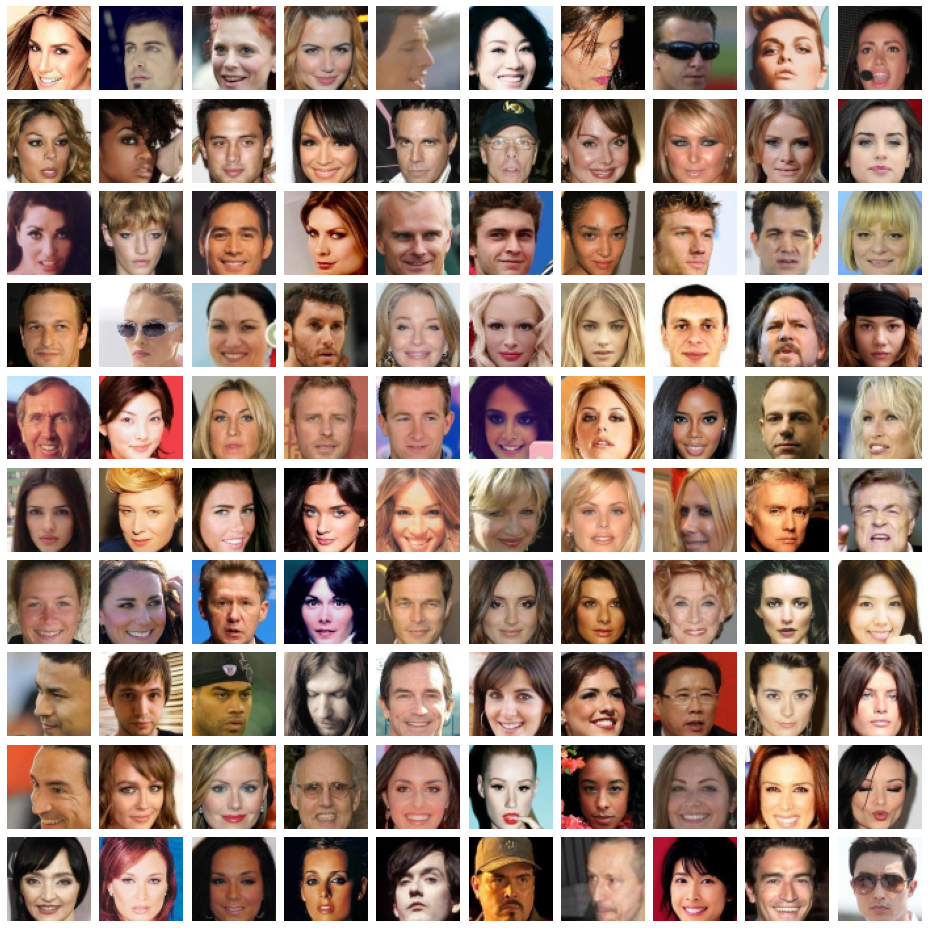

In [0]:
# Re-run this cell to show a new batch of images
images = next(training_viz_iterator)
display_images(images, 10)

## Model


In [0]:
def create_generator():
  return model

In [0]:
def create_discriminator():
  return model

In [0]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  generator = create_generator()
  discriminator = create_discriminator()
generator.summary()
discriminator.summary()

## Training

In [0]:
def train():

## Results